"You Just Want Attention" is a re-implementation of the Attention Is All You Need paper with the Multi30k dataset for German -> English translation

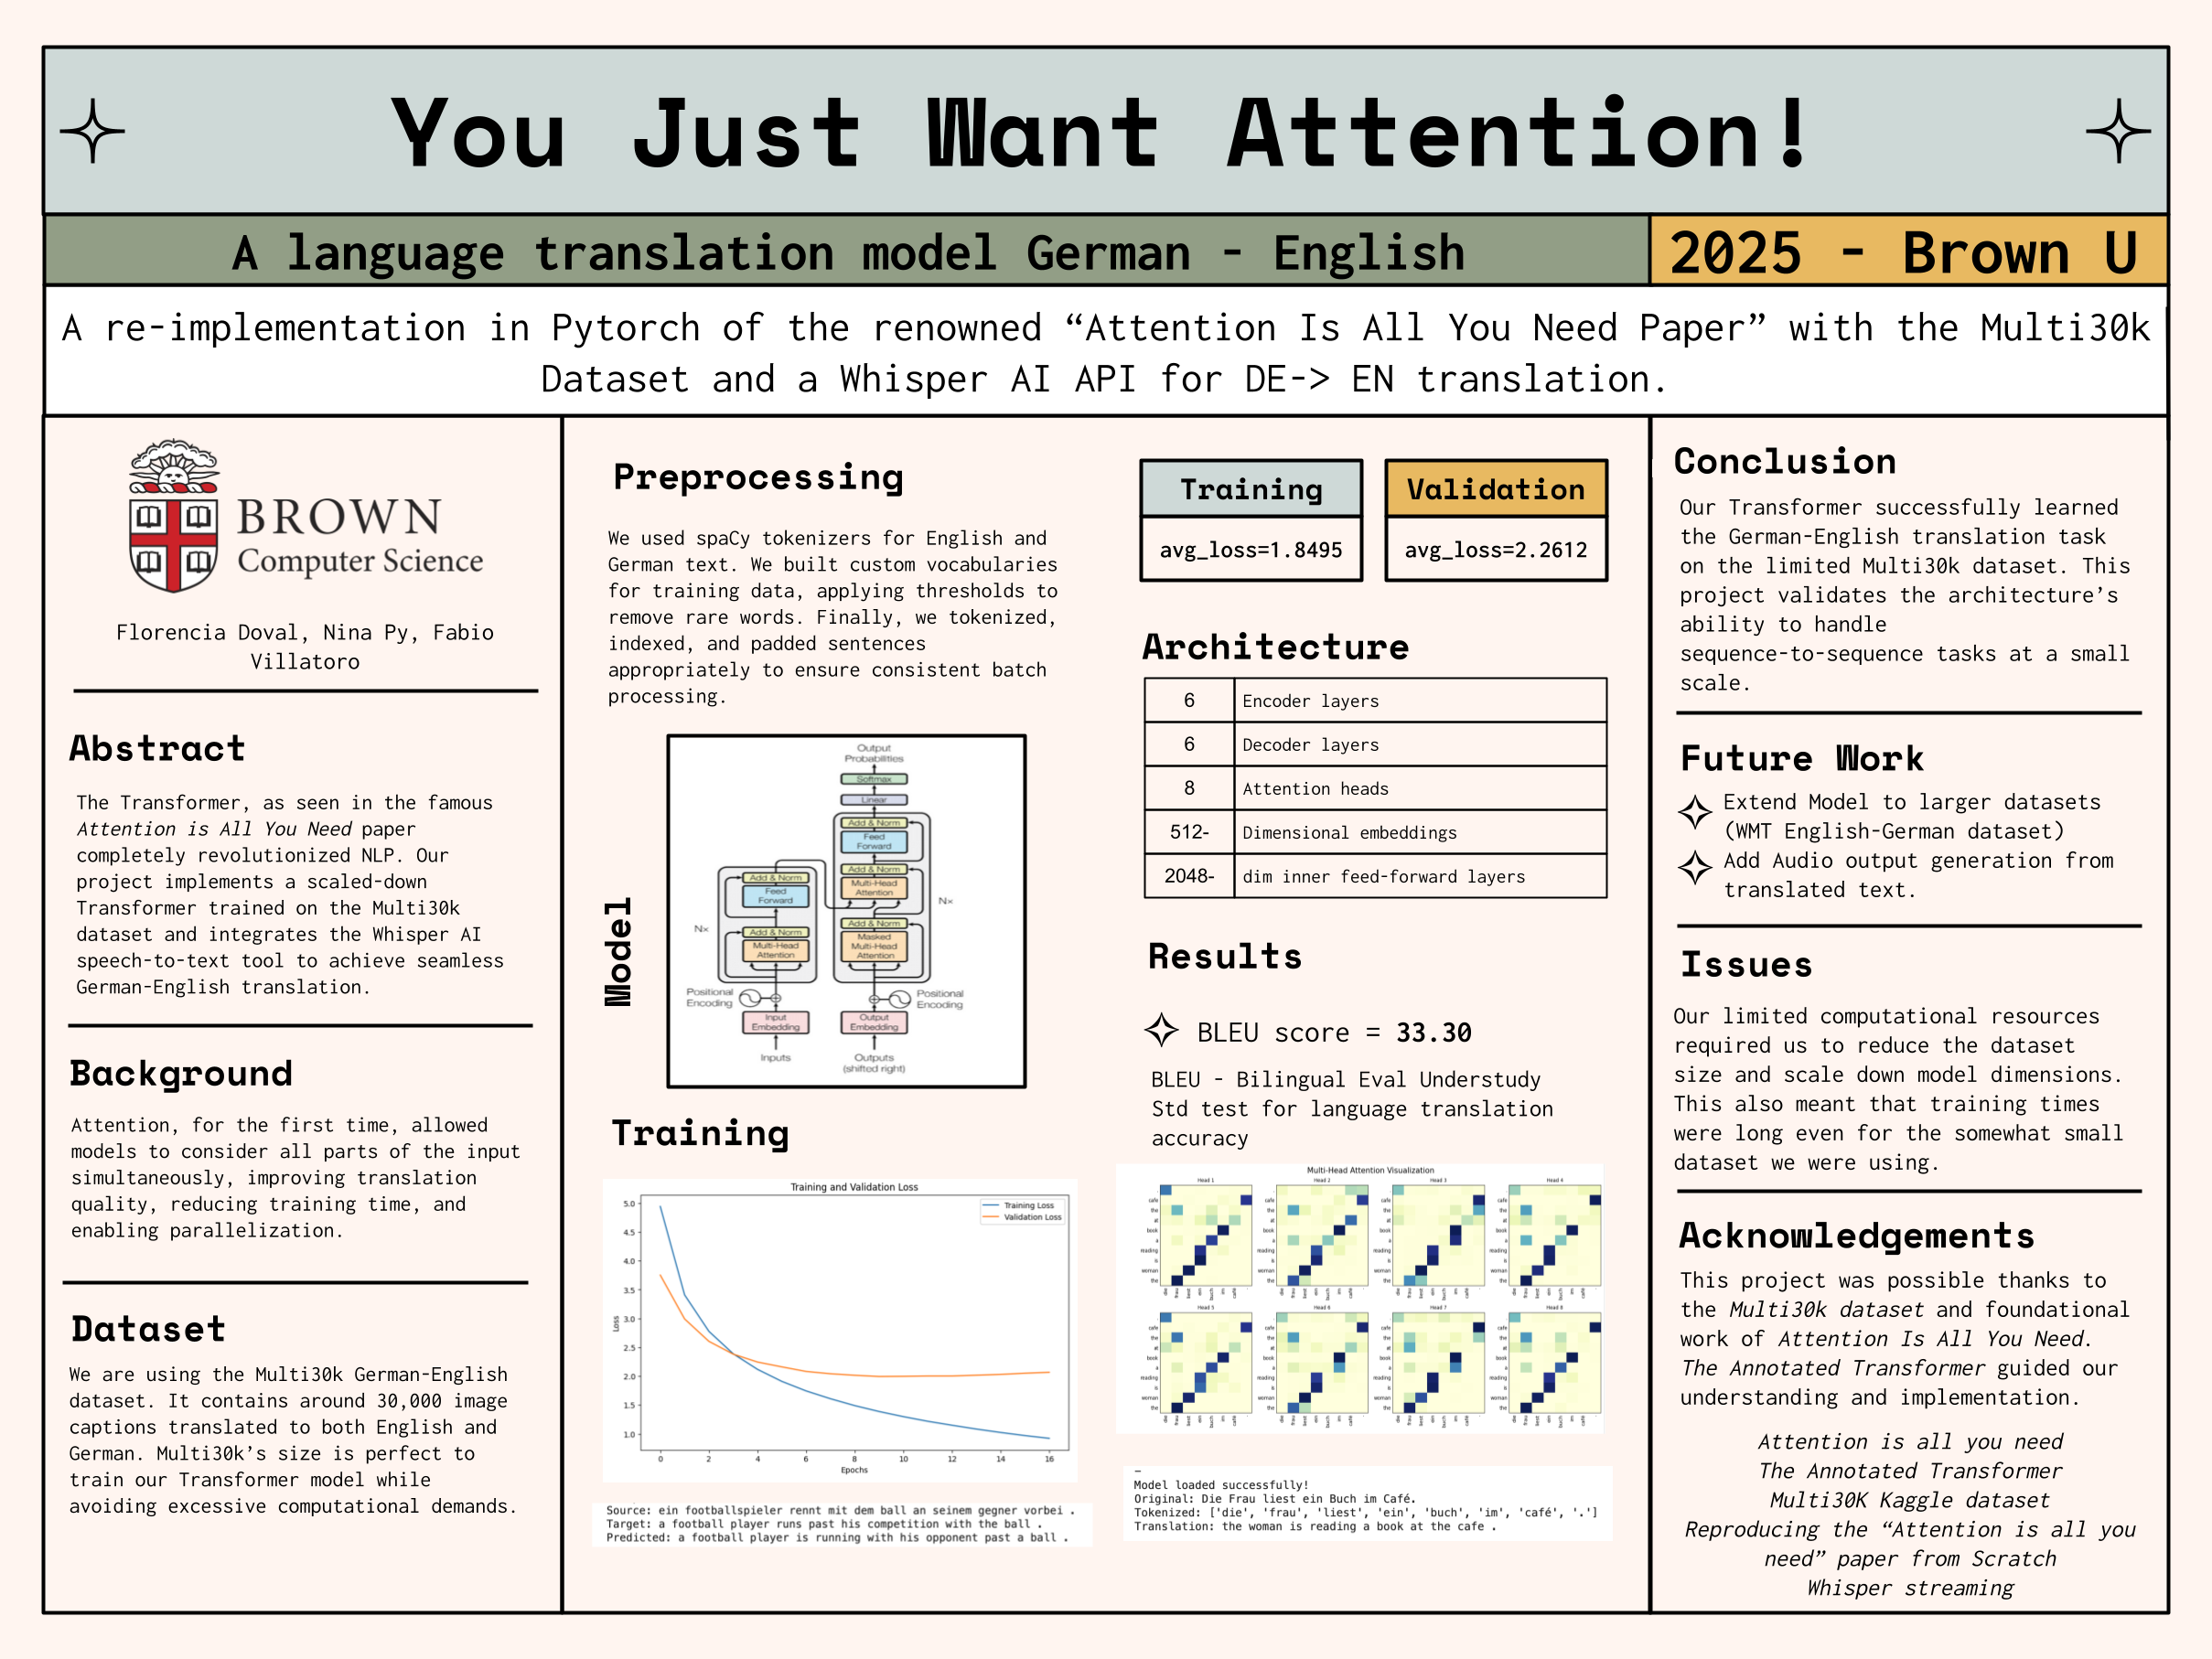

By Florencia Doval, Nina Py Brozovich, Fabio Villatoro ('26)

Please note that you must first download the datasets from Kaggle and upload them to your Drive folder.

**Sources**


*   [The Annotated Transformer](https://nlp.seas.harvard.edu/annotated-transformer/)
*   [Reproducing the “Attention is all you need” Paper from Scratch](https://medium.com/@martin.p.dittgen/reproducing-the-attention-is-all-you-need-paper-from-scratch-d2fb40bb25d4)
*  [ Whisper Streaming](https://github.com/ufal/whisper_streaming)
*   [Multi30k Kaggle Dataset](https://huggingface.co/datasets/bentrevett/multi30k)





Spacy is a library useful for NLP tasks, we later use it for tokenization. Moreover, the en_core and de_core are small language models optimized for efficiency and speed, which also help us with accuracy in our tokenization.

In [ ]:
!pip install numpy

In [ ]:
#install required packages
!pip install torch torchtext==0.15.2 spacy nltk matplotlib
!python -m spacy download en_core_web_sm
!python -m spacy download de_core_news_sm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 25.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 619.9/619.9 MB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.1/317.1 MB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 118.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.0/21.0 MB 101.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.3/849.3 kB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 557.1/557.1 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.4/168.4 MB 14.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.6/54.6 MB 25.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.6/102.6 MB 23.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 173.2/173.2 MB 14.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.1/177.1 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.4/491.4 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 15.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 16.4 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2025.3.0 which is incompatible.


* **tokenize_de:** Tokenizes German text using the German spaCy model
* **tokenize_en:** Tokenizes English text using the English spaCy model

#### Special tokens:
* SOS_TOKEN: Marks the start of a sentence
* EOS_TOKEN: Marks the end of a sentence
* PAD_TOKEN: Used for padding sequences to make them uniform length
* UNK_TOKEN: Represents words not in the vocabulary



In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import math
import spacy
import numpy as np
if not hasattr(np, 'bool'):
    np.bool = np.bool_
import random
import time
from torch.utils.data import Dataset, DataLoader
from datasets import load_dataset
import os
from google.colab import drive
import matplotlib.pyplot as plt

#set seeds to mantain consistency (controlled randomness) during splitting and sampling
SEED = 1234
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

#setting device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

#double-checking that spacy is downloaded
try:
    spacy_de = spacy.load('de_core_news_sm')
    spacy_en = spacy.load('en_core_web_sm')
except OSError:
    print("Downloading spaCy models")
    import os
    os.system("python -m spacy download en_core_web_sm")
    os.system("python -m spacy download de_core_news_sm")
    spacy_de = spacy.load('de_core_news_sm')
    spacy_en = spacy.load('en_core_web_sm')

#defining tokenizers
def tokenize_de(text):
    return [token.text.lower() for token in spacy_de.tokenizer(text)]

def tokenize_en(text):
    return [token.text.lower() for token in spacy_en.tokenizer(text)]

#special tokens
SOS_TOKEN = '<sos>'  #start of sentence
EOS_TOKEN = '<eos>'  #end of sentence
PAD_TOKEN = '<pad>'  #padding token
UNK_TOKEN = '<unk>'  #unknown token


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/usr/local/lib/python3.11/dist-packages/colab_kernel_launcher.py", line 37, in <module>
    ColabKernelApp.launch_instance()
  File "/usr/local/lib/python3.11/dist-packages/traitlets/config/application.py", line 992, in launch_instance
    app.start()
  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelapp.py", line 712, in start
    self.io_loop.start()
  File "/usr/local/lib/python3.11/dist-package

Using device: cuda


## Setting up Tokenizers and the Language Models for en-de (english and german)

# Pre-Processing Data

The following cells will handle data loading and preprocessing. We'll:

* Load the Multi30k dataset (English-German pairs)
* Build vocabularies for both languages
* Create custom dataset and dataloader with batching and padding
* This approach uses the modern PyTorch/TorchText APIs instead of deprecated ones

Dataset downloaded from: https://huggingface.co/datasets/bentrevett/multi30k

In [ ]:
drive.mount('/content/drive')

train_filepaths = {
    'train': '/content/drive/MyDrive/Multi30k datasets/data/training/train.en'
}

#English data first
dataset = load_dataset('csv', data_files=train_filepaths, delimiter='\t', column_names=['en'])

#German data as a new column
with open('/content/drive/MyDrive/Multi30k datasets/data/training/train.de', 'r', encoding='utf-8') as f:
    de_sentences = f.readlines()

dataset = dataset.map(lambda example, idx: {'de': de_sentences[idx].strip()}, with_indices=True)

#tokenization of the data
train_data = dataset['train'].map(
    lambda example: {
        'en_tokens': tokenize_en(example['en']) if example['en'] is not None else [],
        'de_tokens': tokenize_de(example['de']) if example['de'] is not None else []
    }
)

#checking progress
for i in range(3):
    print(f"Example {i + 1}:")
    print(f"English: {train_data[i]['en']}")
    print(f"German: {train_data[i]['de']}")
    print(f"English Tokens: {train_data[i]['en_tokens']}")
    print(f"German Tokens: {train_data[i]['de_tokens']}")
    print("-" * 20)

Mounted at /content/drive


Generating train split: 0 examples [00:00, ? examples/s]

Map:   0%|          | 0/29000 [00:00<?, ? examples/s]

Map:   0%|          | 0/29000 [00:00<?, ? examples/s]

Example 1:
English: Two young, White males are outside near many bushes.
German: Zwei junge weiße Männer sind im Freien in der Nähe vieler Büsche.
English Tokens: ['two', 'young', ',', 'white', 'males', 'are', 'outside', 'near', 'many', 'bushes', '.']
German Tokens: ['zwei', 'junge', 'weiße', 'männer', 'sind', 'im', 'freien', 'in', 'der', 'nähe', 'vieler', 'büsche', '.']
--------------------
Example 2:
English: Several men in hard hats are operating a giant pulley system.
German: Mehrere Männer mit Schutzhelmen bedienen ein Antriebsradsystem.
English Tokens: ['several', 'men', 'in', 'hard', 'hats', 'are', 'operating', 'a', 'giant', 'pulley', 'system', '.']
German Tokens: ['mehrere', 'männer', 'mit', 'schutzhelmen', 'bedienen', 'ein', 'antriebsradsystem', '.']
--------------------
Example 3:
English: A little girl climbing into a wooden playhouse.
German: Ein kleines Mädchen klettert in ein Spielhaus aus Holz.
English Tokens: ['a', 'little', 'girl', 'climbing', 'into', 'a', 'wooden', 'p

## Vocabulary + DataLoader
In this section, we prepare the data for training by:

- Building **vocabularies** for the German (source) and English (target) languages.
- Creating a **custom PyTorch Dataset** that converts tokenized sentences into index sequences.
- Implementing a **collate function** that pads batches to the same length.
- Splitting the dataset into **training**, **validation**, and **test** sets.
- Creating **DataLoaders** that efficiently batch and shuffle the data.

## Why this step?

Before feeding sentences into a Transformer model, we must convert words into integers (vocabulary indices).
Padding is used to ensure that all sentences in a batch are of equal length, which allows us to fully leverage
GPU parallelism (Vaswani et al., 2017, Section 3.1).

Without consistent sentence lengths, training would be extremely inefficient.

## Example

Suppose we have these German sentences:

- "Das ist ein Haus." → ["das", "ist", "ein", "haus", "."]
- "Ein Auto." → ["ein", "auto", "."]

We map each word to an index (e.g., "das" → 7, "ist" → 15, etc.).  
We also pad shorter sentences to match the longest one, like:

| Sentence               | Indices                             |
|------------------------ |-------------------------------------|
| das ist ein haus .      | [7, 15, 23, 99, 3]                 |
| ein auto . pad pad pad  | [23, 45, 3, 1, 1]                  |

where `pad` is the padding token (`<pad>`).

This batching and padding technique is essential for maximizing parallel computation.

> **Reference:** See *Section 3.1 "Encoder and Decoder Stacks"* in [Attention Is All You Need](https://arxiv.org/abs/1706.03762).

In [ ]:
class Vocabulary: #build vocabulary class to map tokens to unique indices
    def __init__(self, specials=None):
        self.token_to_idx = {}
        self.idx_to_token = {}
        self.frequencies = {}

        #add special tokens like <unk>, <pad>, <sos>, <eos>
        if specials:
            for token in specials:
                self.add_token(token, special=True)

    def add_token(self, token, special=False):
        if token not in self.token_to_idx:
            idx = len(self.token_to_idx)
            self.token_to_idx[token] = idx
            self.idx_to_token[idx] = token
            self.frequencies[token] = float('inf') if special else 1
        elif not special:
            self.frequencies[token] += 1

    def __getitem__(self, token):
        return self.token_to_idx.get(token, self.token_to_idx[UNK_TOKEN])

    def __len__(self):
        return len(self.token_to_idx)

    def get_token(self, idx):
        return self.idx_to_token.get(idx, UNK_TOKEN)

    def get_stoi(self):
        return self.token_to_idx

#build source and target vocabularies
def build_vocabularies(dataset, min_freq=2):
    specials = [UNK_TOKEN, PAD_TOKEN, SOS_TOKEN, EOS_TOKEN]
    src_vocab = Vocabulary(specials=specials)
    tgt_vocab = Vocabulary(specials=specials)

    #count token frequencies
    token_freqs = {'de': {}, 'en': {}}

    for example in dataset:
        for token in example['de_tokens']:
            token_freqs['de'][token] = token_freqs['de'].get(token, 0) + 1
        for token in example['en_tokens']:
            token_freqs['en'][token] = token_freqs['en'].get(token, 0) + 1

    #add tokens that appear at least min_freq times
    for token, freq in token_freqs['de'].items():
        if freq >= min_freq:
            src_vocab.add_token(token)

    for token, freq in token_freqs['en'].items():
        if freq >= min_freq:
            tgt_vocab.add_token(token)

    print(f"Source vocabulary size: {len(src_vocab)}")
    print(f"Target vocabulary size: {len(tgt_vocab)}")

    return src_vocab, tgt_vocab

#build vocabularies with minimum frequency of 2
src_vocab, tgt_vocab = build_vocabularies(train_data, min_freq=2)

Source vocabulary size: 7853
Target vocabulary size: 5893


The results mean that the language datasets have 7853 and 5893 unique tokens or "words". This includes the special tokens (UNK_TOKEN, PAD_TOKEN, SOS_TOKEN, EOS_TOKEN)


In [ ]:
#custom dataset class that returns source and target tensors
class TranslationDataset(Dataset):
    def __init__(self, data, src_vocab, tgt_vocab):
        self.data = data
        self.src_vocab = src_vocab
        self.tgt_vocab = tgt_vocab

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]

        #convert tokens to indices and add <sos> and <eos> tokens
        src_indices = [self.src_vocab[token] for token in [SOS_TOKEN] + item['de_tokens'] + [EOS_TOKEN]]
        tgt_indices = [self.tgt_vocab[token] for token in [SOS_TOKEN] + item['en_tokens'] + [EOS_TOKEN]]

        return {
            'src': torch.tensor(src_indices, dtype=torch.long),
            'tgt': torch.tensor(tgt_indices, dtype=torch.long)
        }

#collate function to pad batches to the same length
def collate_fn(batch):
    src_batch = [item['src'] for item in batch]
    tgt_batch = [item['tgt'] for item in batch]

    #pad source and target sequences
    src_batch = nn.utils.rnn.pad_sequence(src_batch, batch_first=True, padding_value=src_vocab[PAD_TOKEN])
    tgt_batch = nn.utils.rnn.pad_sequence(tgt_batch, batch_first=True, padding_value=tgt_vocab[PAD_TOKEN])

    return src_batch, tgt_batch

#split data into train, validation, and test sets
train_size = int(0.8 * len(train_data))
val_size = int(0.1 * len(train_data))
test_size = len(train_data) - train_size - val_size

#use a random generator for reproducible splits
generator = torch.Generator().manual_seed(SEED)
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(
    train_data, [train_size, val_size, test_size], generator=generator
)

#create dataset objects
train_dataset = TranslationDataset(train_dataset, src_vocab, tgt_vocab)
val_dataset = TranslationDataset(val_dataset, src_vocab, tgt_vocab)
test_dataset = TranslationDataset(test_dataset, src_vocab, tgt_vocab)

BATCH_SIZE = 128 #high number to prevent overfitting

#create DataLoaders for batching
train_dataloader = DataLoader(
    train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn
)
val_dataloader = DataLoader(
    val_dataset, batch_size=BATCH_SIZE, collate_fn=collate_fn
)
test_dataloader = DataLoader(
    test_dataset, batch_size=BATCH_SIZE, collate_fn=collate_fn
)

#inspect a sample batch
for src, tgt in train_dataloader:
    print(f"Source batch shape: {src.shape}")
    print(f"Target batch shape: {tgt.shape}")

    idx = 0
    print("\nExample sentence:")
    print(f"Source: {' '.join([src_vocab.get_token(idx.item()) for idx in src[idx]])}")
    print(f"Target: {' '.join([tgt_vocab.get_token(idx.item()) for idx in tgt[idx]])}")
    break

Source batch shape: torch.Size([128, 26])
Target batch shape: torch.Size([128, 24])

Example sentence:
Source: <sos> eine <unk> frau geht durch eine seitenstraße in einer großstadt . <eos> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Target: <sos> a <unk> woman walks down a metropolitan side street . <eos> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>


 Data was batched with a batch size of 128 and padded to a maximum sequence length of 32 for the source and 31 for the target.

# Transformer Model
# Building the Transformer Model

This section implements the full **Transformer** architecture, introduced by Vaswani et al., 2017.

We built the following core components:

- **Learnable Positional Encoding:** Injects information about token order, allowing the model to handle sequences without recurrence (Vaswani et al., Section 3.4).
- **Multi-Head Attention Mechanism:** Allows the model to attend to information from different representation subspaces at different positions (Section 3.2).
- **Feed-Forward Networks:** Applied to each position separately and identically (Section 3.3).
- **Encoder Stack:** A sequence of layers each composed of self-attention and feed-forward sublayers (Section 3.1).
- **Decoder Stack:** Similar to the encoder, but includes masked self-attention and encoder-decoder attention (Section 3.1).

Finally, we wrap everything inside a **Transformer class** that handles the masking, forward pass, and initialization.

---

## Why is this architecture important?

- **No Recurrence:** Unlike RNNs, Transformers rely purely on attention mechanisms, allowing for much more parallelization during training.
- **Position matters:** Since attention is permutation invariant, we must inject positional information explicitly.
- **Multiple Attention Heads:** The model can focus on different parts of the sequence simultaneously.

> **Reference:** *Attention Is All You Need*, Sections 3 and 3.2, https://arxiv.org/abs/1706.03762



In [ ]:
#define positional encoding as a learnable embedding
class LearnablePositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        self.pe = nn.Embedding(max_len, d_model)
        self.register_buffer('position_ids', torch.arange(max_len).expand((1, -1)))

    def forward(self, x): #add positional embeddings to token embeddings
        """
        x: (batch_size, seq_len, d_model)
        """
        position_ids = self.position_ids[:, :x.size(1)].to(x.device)
        return x + self.pe(position_ids)


In [ ]:
#multi-head self-attention layer
class MultiHeadAttention(nn.Module):
    """
    Multi-Head Attention sublayer.

    Given queries, keys, and values (Q, K, V), it produces an output
    by performing scaled dot-product attention in multiple heads, then
    concatenates the results.
    """
    #allows the model to focus on different parts of the sequence

    def __init__(self, d_model, n_heads, dropout=0.1):
        super().__init__()
        assert d_model % n_heads == 0, "d_model must be divisible by n_heads."

        self.d_model = d_model
        self.n_heads = n_heads
        self.head_dim = d_model // n_heads

        #define linear layers for query, key, and value
        self.w_q = nn.Linear(d_model, d_model)
        self.w_k = nn.Linear(d_model, d_model)
        self.w_v = nn.Linear(d_model, d_model)

        #output projection
        self.fc_out = nn.Linear(d_model, d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, query, key, value, mask=None):
        B = query.size(0)

        #apply linear projections
        Q = self.w_q(query)
        K = self.w_k(key)
        V = self.w_v(value)

        #split into multiple heads
        Q = Q.view(B, -1, self.n_heads, self.head_dim).transpose(1, 2)
        K = K.view(B, -1, self.n_heads, self.head_dim).transpose(1, 2)
        V = V.view(B, -1, self.n_heads, self.head_dim).transpose(1, 2)

        #compute scaled dot-product attention
        energy = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(self.head_dim)

        if mask is not None:
            energy = energy.masked_fill(mask == 0, float('-inf'))

        attention = torch.softmax(energy, dim=-1)
        attention = self.dropout(attention)

        #apply attention to values
        x = torch.matmul(attention, V)
        x = x.transpose(1, 2).contiguous()
        x = x.view(B, -1, self.d_model)

        #final linear projection
        x = self.fc_out(x)
        return x, attention

In [ ]:
#position-wise feed-forward network
class PositionwiseFeedForward(nn.Module):
    """
    Implements the two-layer feed-forward network used in the Transformer:
    FFN(x) = max(0, xW1 + b1)W2 + b2
    """
    def __init__(self, d_model, dim_feedforward=2048, dropout=0.1):
        super().__init__()
        self.linear1 = nn.Linear(d_model, dim_feedforward)
        self.linear2 = nn.Linear(dim_feedforward, d_model)
        self.dropout = nn.Dropout(dropout)
        self.relu = nn.ReLU()

    def forward(self, x): #apply two linear transformations with relu activation
        #project up -> apply ReLU -> dropout -> project down
        x = self.linear1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.linear2(x)
        return x

In [ ]:
#single encoder layer with self-attention and feed-forward
class EncoderLayer(nn.Module):
    """
    Single Transformer encoder layer, made up of:
      - Multi-Head Self-Attention (with residual & layer norm)
      - Position-wise Feed Forward (with residual & layer norm)
    """
    def __init__(self, d_model, n_heads, dim_feedforward, dropout):
        super().__init__()
        self.self_attn = MultiHeadAttention(d_model, n_heads, dropout)
        self.ff = PositionwiseFeedForward(d_model, dim_feedforward, dropout)

        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, src, src_mask=None):
        #apply self-attention sublayer
        attn_output, _ = self.self_attn(src, src, src, mask=src_mask)
        src = self.norm1(src + self.dropout(attn_output))

        #apply feed-forward sublayer
        ff_output = self.ff(src)
        src = self.norm2(src + self.dropout(ff_output))
        return src

#encoder consisting of multiple encoder layers
class Encoder(nn.Module):
    """
    Transformer Encoder that stacks multiple EncoderLayer layers.
    """
    def __init__(self, input_dim, d_model, n_layers, n_heads, dim_feedforward, dropout, max_len=5000):
        super().__init__()
        self.d_model = d_model

        #token embedding
        self.embed_tokens = nn.Embedding(input_dim, d_model)

        #positional encoding
        self.pos_encoding = LearnablePositionalEncoding(d_model, max_len)

        #dropout after embedding
        self.dropout = nn.Dropout(dropout)

        #stack of EncoderLayers
        self.layers = nn.ModuleList([
            EncoderLayer(d_model, n_heads, dim_feedforward, dropout)
            for _ in range(n_layers)
        ])

    def forward(self, src, src_mask=None):
        #embed tokens + scale
        src_embed = self.embed_tokens(src) * math.sqrt(self.d_model)
        #add positional encoding
        src_embed = self.pos_encoding(src_embed)
        #apply dropout
        src_embed = self.dropout(src_embed)

        #pass through each layer
        out = src_embed
        for layer in self.layers:
            out = layer(out, src_mask)

        return out

In [ ]:
#single decoder layer with masked self-attention and encoder-decoder attention
class DecoderLayer(nn.Module):
    """
    Single Transformer decoder layer, made up of:
      - Masked Multi-Head Self-Attention (with residual & layer norm)
      - Multi-Head Attention over Encoder output (with residual & layer norm)
      - Position-wise Feed Forward (with residual & layer norm)
    """
    def __init__(self, d_model, n_heads, dim_feedforward, dropout):
        super().__init__()
        #self-attention for the target tokens
        self.self_attn = MultiHeadAttention(d_model, n_heads, dropout)
        #cross-attention: query is the decoder, key/value is the encoder output
        self.cross_attn = MultiHeadAttention(d_model, n_heads, dropout)
        self.ff = PositionwiseFeedForward(d_model, dim_feedforward, dropout)

        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.norm3 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, tgt, enc_out, tgt_mask=None, src_mask=None):
        #masked self-attention
        self_attn_out, _ = self.self_attn(tgt, tgt, tgt, mask=tgt_mask)
        x = self.norm1(tgt + self.dropout(self_attn_out))

        #Encoder-Decoder cross-attention
        cross_attn_out, attn_weights = self.cross_attn(x, enc_out, enc_out, mask=src_mask)
        x = self.norm2(x + self.dropout(cross_attn_out))

        #position-wise feed forward
        ff_out = self.ff(x)
        out = self.norm3(x + self.dropout(ff_out))

        return out, attn_weights

#decoder consisting of multiple decoder layers
class Decoder(nn.Module):
    """
    Transformer Decoder that stacks multiple DecoderLayer layers.
    """
    def __init__(self, output_dim, d_model, n_layers, n_heads, dim_feedforward, dropout, max_len=5000):
        super().__init__()
        self.d_model = d_model

        #embedding for target tokens
        self.embed_tokens = nn.Embedding(output_dim, d_model)

        #positional encoding
        self.pos_encoding = LearnablePositionalEncoding(d_model, max_len)

        #dropout after embedding
        self.dropout = nn.Dropout(dropout)

        #stack of DecoderLayers
        self.layers = nn.ModuleList([
            DecoderLayer(d_model, n_heads, dim_feedforward, dropout)
            for _ in range(n_layers)
        ])

        #final linear layer to map to output vocab
        self.fc_out = nn.Linear(d_model, output_dim, bias=False)
        self.embed_tokens = nn.Embedding(output_dim, d_model)

        #share weights
        self.fc_out.weight = self.embed_tokens.weight

    def forward(self, tgt, enc_out, tgt_mask=None, src_mask=None):
        #embed + scale
        tgt_embed = self.embed_tokens(tgt) * math.sqrt(self.d_model)

        #add position encodings
        tgt_embed = self.pos_encoding(tgt_embed)
        tgt_embed = self.dropout(tgt_embed)

        #pass through each layer
        out = tgt_embed
        attn_weights = None
        for layer in self.layers:
            out, attn_weights = layer(out, enc_out, tgt_mask, src_mask)

        #project hidden states to vocab logits
        logits = self.fc_out(out)

        return logits, attn_weights

In [ ]:
#complete transformer model combining encoder and decoder
class Transformer(nn.Module):
    """
    Complete Transformer: an Encoder and a Decoder, with the ability to
    generate source/target masks based on pad tokens or future tokens.
    """
    def __init__(self,
                 src_vocab_size,
                 tgt_vocab_size,
                 d_model=512,
                 n_layers=6,
                 n_heads=8,
                 dim_feedforward=2048,
                 dropout=0.1,
                 src_pad_idx=1,
                 tgt_pad_idx=1,
                 max_len=5000):
        super().__init__()

        #padding indices
        self.src_pad_idx = src_pad_idx
        self.tgt_pad_idx = tgt_pad_idx

        #initialize encoder and decoder
        self.encoder = Encoder(src_vocab_size, d_model, n_layers, n_heads,
                              dim_feedforward, dropout, max_len)
        self.decoder = Decoder(tgt_vocab_size, d_model, n_layers, n_heads,
                              dim_feedforward, dropout, max_len)

        #initialize parameters with xavier uniform
        for p in self.parameters():
            if p.dim() > 1:
                nn.init.xavier_uniform_(p)

    def make_src_mask(self, src): #create mask for source to ignore pad tokens
        """
        Creates a binary mask for the source sequence to ignore PAD tokens.
        """
        #pad mask, True where src is not a pad index
        src_mask = (src != self.src_pad_idx).unsqueeze(1).unsqueeze(2)
        return src_mask

    def make_tgt_mask(self, tgt):
        """
        Creates a mask for the target sequence to:
            1) ignore PAD tokens,
            2) apply subsequent/future masking so we don't look ahead.
        """
        #get batch size and target sequence length
        B, tgt_len = tgt.shape

        #pad mask, True where src is not a pad index
        pad_mask = (tgt != self.tgt_pad_idx).unsqueeze(1).unsqueeze(2)

        #subsequent mask (no looking ahead)
        subsequent_mask = torch.tril(torch.ones((tgt_len, tgt_len), device=tgt.device)).bool()
        subsequent_mask = subsequent_mask.unsqueeze(0).unsqueeze(1)

        #combine pad mask and subsequent mask
        #only allow attention on non-padding tokens and positions up current time step
        tgt_mask = pad_mask & subsequent_mask
        return tgt_mask

    def forward(self, src, tgt):
        #masks for source input and target input
        src_mask = self.make_src_mask(src)
        tgt_mask = self.make_tgt_mask(tgt)

        enc_out = self.encoder(src, src_mask) #encoder takes source sequence
        logits, attention = self.decoder(tgt, enc_out, tgt_mask, src_mask) #decoder takes target sequence and encoder output
        return logits, attention

# 4. Training Loop Setup

In this section, we define the training and evaluation logic for our Transformer model.

**Steps involved:**

- **Initialize the Transformer** with custom hyperparameters (smaller model to avoid overfitting).
- **Define the optimizer** (Adam) and **scheduler** (ReduceLROnPlateau) to adapt the learning rate during training.
- **Label Smoothing Loss:** Improves generalization by softening the one-hot labels, as discussed in Vaswani et al., Section 5.4.
- **Train function:** Performs a forward pass, computes the loss, applies backpropagation, and updates the weights.
- **Evaluate function:** Calculates validation loss without updating the model.

---

## About Model Parameters

> The model has **10,032,640 trainable parameters**

It means there are **10 million** (weights and biases) in the model that will be updated during training. These parameters are distributed across all parts of the Transformer: embeddings, attention heads, feed-forward layers, etc.

---

## Why Label Smoothing?

Instead of training the model to predict exactly the correct class (hard targets), we slightly smooth the targets, making the model less confident and improving generalization.

This technique is **introduced in Vaswani et al., 2017 (Section 5.4)** as a regularization method to avoid overfitting.


In [ ]:
#get padding indices for source and target
SRC_PAD_IDX = src_vocab[PAD_TOKEN]
TGT_PAD_IDX = tgt_vocab[PAD_TOKEN]

#define transformer hyperparameters
D_MODEL = 256  # Reduced from 512
N_LAYERS = 3   # Reduced from 6
N_HEADS = 8    # Reduced from 8
DIM_FEEDFORWARD = 512  # Reduced from 2048
DROPOUT = 0.1  # Increased from 0.1 to prevent overfitting
LEARNING_RATE = 0.0003  # Slightly reduced learning rate

#define transformer hyperparameters
model = Transformer(
    src_vocab_size=len(src_vocab),
    tgt_vocab_size=len(tgt_vocab),
    d_model=D_MODEL,
    n_layers=N_LAYERS,
    n_heads=N_HEADS,
    dim_feedforward=DIM_FEEDFORWARD,
    dropout=DROPOUT,
    src_pad_idx=SRC_PAD_IDX,
    tgt_pad_idx=TGT_PAD_IDX
).to(device)

#print number of trainable parameters
print(f'The model has {sum(p.numel() for p in model.parameters() if p.requires_grad):,} trainable parameters')

#define optimizer with weight decay for regularization
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-4)

class LabelSmoothingLoss(nn.Module):
    def __init__(self, label_smoothing, tgt_vocab_size, ignore_index=0):
        super().__init__()
        self.criterion = nn.KLDivLoss(reduction='batchmean')
        self.label_smoothing = label_smoothing
        self.tgt_vocab_size = tgt_vocab_size
        self.ignore_index = ignore_index

    def forward(self, output, target):
        # output: (batch_size * seq_len, vocab_size)
        # target: (batch_size * seq_len)
        #apply log softmax to outputs
        output = output.log_softmax(dim=-1)

        true_dist = torch.zeros_like(output) #initialize true distribution
        true_dist.fill_(self.label_smoothing / (self.tgt_vocab_size - 2))
        ignore = target == self.ignore_index #ignore padding tokens
        target = target.masked_fill(ignore, 0) #scatter correct labels
        true_dist.scatter_(1, target.unsqueeze(1), 1.0 - self.label_smoothing)
        true_dist.masked_fill_(ignore.unsqueeze(1), 0)

        return self.criterion(output, true_dist)

#define cross-entropy loss ignoring pad index
criterion = nn.CrossEntropyLoss(ignore_index=TGT_PAD_IDX)

#define learning rate scheduler to reduce lr on plateau
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=7, verbose=True
)

The model has 10,032,640 trainable parameters


In [ ]:
#training function
def train(model, dataloader, optimizer, criterion, clip):
    model.train()
    epoch_loss = 0

    for i, (src, tgt) in enumerate(dataloader):
        src, tgt = src.to(device), tgt.to(device)

        optimizer.zero_grad()

        #forward pass with teacher forcing
        output, _ = model(src, tgt[:, :-1])

        #reshape output and target for loss computation
        output_dim = output.shape[-1]
        output = output.contiguous().view(-1, output_dim)
        tgt = tgt[:, 1:].contiguous().view(-1)

        #compute loss
        loss = criterion(output, tgt)

        #backward pass and optimization
        loss.backward()
        # Gradient clipping to prevent exploding gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()

        epoch_loss += loss.item()

        if (i+1) % 50 == 0:
            print(f'Batch {i+1}/{len(dataloader)}, Loss: {loss.item():.4f}')

    return epoch_loss / len(dataloader)

#evaluation function
def evaluate(model, dataloader, criterion):
    model.eval()
    epoch_loss = 0

    with torch.no_grad():
        for src, tgt in dataloader:
            src, tgt = src.to(device), tgt.to(device)

            #forward pass
            output, _ = model(src, tgt[:, :-1])

            #reshape output and target
            output_dim = output.shape[-1]
            output = output.contiguous().view(-1, output_dim)
            tgt = tgt[:, 1:].contiguous().view(-1)

            #compute loss
            loss = criterion(output, tgt)

            epoch_loss += loss.item()

    return epoch_loss / len(dataloader)

Batch 50/182, Loss: 5.2018
Batch 100/182, Loss: 4.4810
Batch 150/182, Loss: 3.9840
New best model saved!
Epoch: 01 | Time: 0.0m 9.80s
	Train Loss: 4.9429 | Valid Loss: 3.7526
	Learning Rate: 0.0003000
Batch 50/182, Loss: 3.4384
Batch 100/182, Loss: 3.3756
Batch 150/182, Loss: 3.2099
New best model saved!
Epoch: 02 | Time: 0.0m 9.09s
	Train Loss: 3.4098 | Valid Loss: 2.9928
	Learning Rate: 0.0003000
Batch 50/182, Loss: 2.6670
Batch 100/182, Loss: 2.8019
Batch 150/182, Loss: 2.5920
New best model saved!
Epoch: 03 | Time: 0.0m 9.05s
	Train Loss: 2.7774 | Valid Loss: 2.6039
	Learning Rate: 0.0003000
Batch 50/182, Loss: 2.4182
Batch 100/182, Loss: 2.4410
Batch 150/182, Loss: 2.3865
New best model saved!
Epoch: 04 | Time: 0.0m 9.21s
	Train Loss: 2.3882 | Valid Loss: 2.3820
	Learning Rate: 0.0003000
Batch 50/182, Loss: 2.1446
Batch 100/182, Loss: 2.1176
Batch 150/182, Loss: 2.1108
New best model saved!
Epoch: 05 | Time: 0.0m 9.16s
	Train Loss: 2.1182 | Valid Loss: 2.2448
	Learning Rate: 0.000

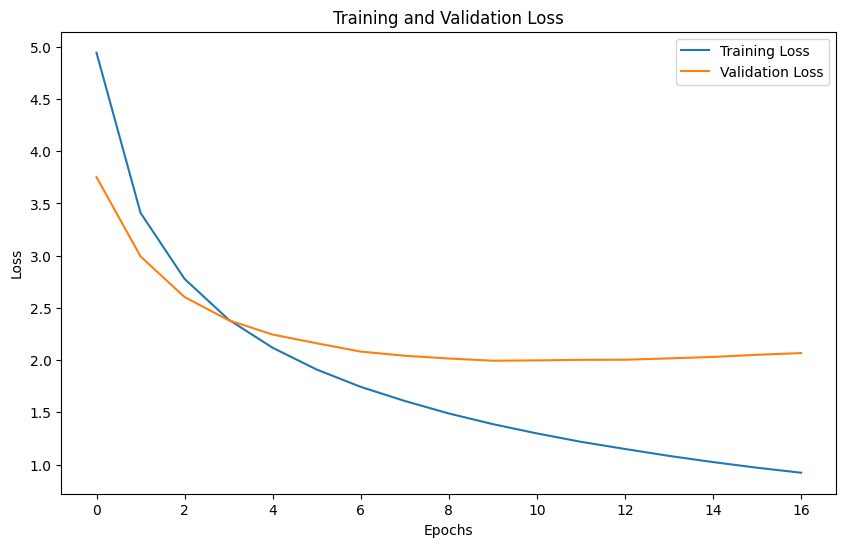

Average Training Loss: 1.8495
Average Validation Loss: 2.2612


In [ ]:
#training loop with early stopping
def train_model(model, train_dataloader, valid_dataloader, optimizer, criterion, scheduler, N_EPOCHS=10, CLIP=1.0, patience=7):
    best_valid_loss = float('inf')
    counter = 0  #early stopping counter
    train_losses = []
    valid_losses = []

    for epoch in range(N_EPOCHS):
        start_time = time.time()

        train_loss = train(model, train_dataloader, optimizer, criterion, CLIP)
        valid_loss = evaluate(model, valid_dataloader, criterion)

        #step the scheduler
        scheduler.step(valid_loss)

        end_time = time.time()
        epoch_mins, epoch_secs = divmod(end_time - start_time, 60)

        #save losses for plotting
        train_losses.append(train_loss)
        valid_losses.append(valid_loss)

        #save model if validation loss is improved
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            torch.save(model.state_dict(), 'transformer-model-best.pt')
            print(f"New best model saved!")
            counter = 0  #reset early stopping counter
        else:
            counter += 1  #increment counter if no improvement

        print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs:.2f}s')
        print(f'\tTrain Loss: {train_loss:.4f} | Valid Loss: {valid_loss:.4f}')
        print(f'\tLearning Rate: {optimizer.param_groups[0]["lr"]:.7f}')

        #early stopping
        if counter >= patience:
            print(f"Early stopping after {epoch+1} epochs with no improvement")
            break

    #plot loss curves
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(valid_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')
    plt.savefig('loss_curve.png')
    plt.show()

    return train_losses, valid_losses

#parameters
N_EPOCHS = 20  #high num epochs but early stopping
CLIP = 1.0
PATIENCE = 7  #early stopping patience

#train model
train_losses, valid_losses = train_model(
    model,
    train_dataloader,
    val_dataloader,
    optimizer,
    criterion,
    scheduler,
    N_EPOCHS=N_EPOCHS,
    CLIP=CLIP,
    patience=PATIENCE
)

#compute average train loss and validation loss
avg_train_loss = np.mean(train_losses)
avg_valid_loss = np.mean(valid_losses)

print(f"Average Training Loss: {avg_train_loss:.4f}")
print(f"Average Validation Loss: {avg_valid_loss:.4f}")

# Translation!

In [ ]:
def translate_sentence(model, sentence, src_vocab, tgt_vocab, device, max_len=50, return_attention=False):
    model.eval()

    #tokenize input sentence and add <sos>, <eos> tokens
    if isinstance(sentence, str):
        tokens = [SOS_TOKEN] + tokenize_de(sentence) + [EOS_TOKEN]
    else:
        tokens = [SOS_TOKEN] + sentence + [EOS_TOKEN]

    #convert tokens to corresponding indices from source vocabulary
    src_indices = [src_vocab[token] for token in tokens]
    src_tensor = torch.LongTensor(src_indices).unsqueeze(0).to(device)

    #pad mask for source sentence
    src_mask = model.make_src_mask(src_tensor)

    #encode source sequence
    with torch.no_grad():
        enc_src = model.encoder(src_tensor, src_mask)

    tgt_indices = [tgt_vocab[SOS_TOKEN]]
    outputs = []
    attentions = []

    #translate one token at-a-time
    for _ in range(max_len):
        tgt_tensor = torch.LongTensor(tgt_indices).unsqueeze(0).to(device)
        tgt_mask = model.make_tgt_mask(tgt_tensor) #mask target sequence (no peeking ahead)

        with torch.no_grad(): #decode with target and encoder output
            output, attention = model.decoder(tgt_tensor, enc_src, tgt_mask, src_mask)

        output = output[:, -1, :] #get predicted token from last position
        pred_token = output.argmax(1).item() #get index of highest-probability token

        #save prediction and attention weights
        outputs.append(pred_token)
        attentions.append(attention)

        #stop if model predicts <eos>
        if pred_token == tgt_vocab[EOS_TOKEN]:
            break

        #append predicted token to target sequence
        tgt_indices.append(pred_token)

    #convert predicted indices to tokens
    pred_tokens = [tgt_vocab.get_token(idx) for idx in outputs]

    if return_attention:
        return pred_tokens, attentions[-1]
    else:
        return pred_tokens, None


In [ ]:
#visualize all attention heads
def display_attention_all_heads(sentence, translation, attention):
    """
    Plot attention heatmaps across all heads using matplotlib, similar to Vaswani et al. (2017) paper.
    """
    import matplotlib.pyplot as plt
    import numpy as np

    if attention is None:
        print("No attention weights available.")
        return

    #clean special tokens
    clean_sentence = [t for t in sentence if t not in [SOS_TOKEN, EOS_TOKEN, PAD_TOKEN]]
    clean_translation = [t for t in translation if t not in [SOS_TOKEN, EOS_TOKEN, PAD_TOKEN]]

    attention = attention.squeeze(0)
    n_heads = attention.shape[0]

    #subplots for each attention head
    fig, axes = plt.subplots(2, (n_heads + 1) // 2, figsize=(3.5 * ((n_heads + 1) // 2), 7))

    if n_heads == 1:
        axes = np.array([[axes]])

    axes = axes.flatten()

    #loop through each attention head
    for i, ax in enumerate(axes):
        if i < n_heads:
            attn = attention[i, :len(clean_translation), :len(clean_sentence)].detach().cpu().numpy()
            im = ax.imshow(attn, aspect='auto', origin='lower', cmap='YlGnBu') #display as heatmap
            ax.set_xticks(np.arange(len(clean_sentence)))
            ax.set_yticks(np.arange(len(clean_translation)))
            ax.set_xticklabels(clean_sentence, rotation=90)
            ax.set_yticklabels(clean_translation)
            ax.set_title(f'Head {i+1}', fontsize=10)
            ax.tick_params(axis='both', which='both', length=0)
        else:
            ax.axis('off')

    plt.tight_layout()
    plt.suptitle('Multi-Head Attention Visualization', y=1.02, fontsize=16)
    plt.show()


In [ ]:
#load best model
model.load_state_dict(torch.load('transformer-model-best.pt'))

#test model on examples from test set
def test_translation(model, test_dataloader, src_vocab, tgt_vocab, device, n=5):
    model.eval()
    examples = []

    #get examples from test set
    for src, tgt in test_dataloader:
        if len(examples) >= n:
            break
        for i in range(min(n - len(examples), len(src))):
            examples.append((src[i].tolist(), tgt[i].tolist()))

    for idx, (src, tgt) in enumerate(examples):
        #convert indices to tokens
        src_tokens = [src_vocab.get_token(idx) for idx in src]
        tgt_tokens = [tgt_vocab.get_token(idx) for idx in tgt]

        #remove special tokens
        src_tokens = [t for t in src_tokens if t not in [SOS_TOKEN, EOS_TOKEN, PAD_TOKEN]]
        tgt_tokens = [t for t in tgt_tokens if t not in [SOS_TOKEN, EOS_TOKEN, PAD_TOKEN]]

        #translate
        translation, attention = translate_sentence(model, src_tokens, src_vocab, tgt_vocab, device)

        #remove EOS token if present
        if EOS_TOKEN in translation:
            translation = translation[:translation.index(EOS_TOKEN)]

        print(f"Example {idx+1}:")
        print(f"Source: {' '.join(src_tokens)}")
        print(f"Target: {' '.join(tgt_tokens)}")
        print(f"Predicted: {' '.join(translation)}")
        print("-" * 50)

#test translations on 5 examples
test_translation(model, test_dataloader, src_vocab, tgt_vocab, device, n=5)

Example 1:
Source: viele asiatische frauen in hellblauen hemden , gehen draußen spazieren .
Target: a lot of asian women walking outside in light blue shirts .
Predicted: many asian women in light light blue shirts walking outside .
--------------------------------------------------
Example 2:
Source: zwei menschen in einer gelben seilbahn küssen sich .
Target: two people kissing on a yellow cable car .
Predicted: two people in a yellow kissing in a line .
--------------------------------------------------
Example 3:
Source: zwei teams spielen in einem stadion hockey und das gelbe team hat gerade ein tor geschossen .
Target: two teams playing hockey in a stadium , the team in yellow just <unk> a point .
Predicted: two teams are playing hockey and the team has hockey player who is kicking the goal .
--------------------------------------------------
Example 4:
Source: ein footballspieler rennt mit dem ball an seinem gegner vorbei .
Target: a football player runs past his competition wit

In [ ]:
!pip install numpy

In [ ]:
#visualize the first attention head (only one)
def display_attention(sentence, translation, attention):
    """
    Visualize attention weights as a heatmap.

    Args:
        sentence: List of tokens in the source sentence (input)
        translation: List of tokens in the predicted output (target)
        attention: Attention weights from the final decoder layer
                   Shape expected: (1, n_heads, tgt_len, src_len)
    """
    import matplotlib.pyplot as plt
    import matplotlib.ticker as ticker
    import numpy as np

    #clean special tokens
    clean_sentence = [t for t in sentence if t not in [SOS_TOKEN, EOS_TOKEN, PAD_TOKEN]]
    clean_translation = [t for t in translation if t not in [SOS_TOKEN, EOS_TOKEN, PAD_TOKEN]]

    #remove EOS token if present
    if EOS_TOKEN in clean_translation:
        clean_translation = clean_translation[:clean_translation.index(EOS_TOKEN)]

    if attention is not None:
        #get attention for 1st head
        attn = attention[0, 0].cpu().detach().numpy()

        attn = attn[:len(clean_translation), :len(clean_sentence)]

        #plot attention heatmap
        fig = plt.figure(figsize=(12, 8))
        ax = fig.add_subplot(111)

        #display as heatmap
        cax = ax.matshow(attn, cmap='bone')
        fig.colorbar(cax)

        ax.set_xticks(np.arange(len(clean_sentence)))
        ax.set_yticks(np.arange(len(clean_translation)))

        ax.set_xticklabels(clean_sentence, rotation=90)
        ax.set_yticklabels(clean_translation)

        ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
        ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

        plt.xlabel("Source Sentence (German)")
        plt.ylabel("Predicted Translation (English)")
        plt.title("Attention Heatmap")
        plt.tight_layout()
        plt.show()
    else:
        print("No attention weights available.")


In [ ]:
#save model with vocabularies
def save_model(model, src_vocab, tgt_vocab, optimizer, filename):
    torch.save({
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'src_vocab': src_vocab,
        'tgt_vocab': tgt_vocab,
        'model_hyperparams': {
            'd_model': D_MODEL,
            'n_layers': N_LAYERS,
            'n_heads': N_HEADS,
            'dim_feedforward': DIM_FEEDFORWARD,
            'dropout': DROPOUT
        }
    }, filename)
    print(f"Model saved to {filename}")

#load saved model
def load_model(filename, device):
    checkpoint = torch.load(filename, map_location=device)

    #get vocabularies
    src_vocab = checkpoint['src_vocab']
    tgt_vocab = checkpoint['tgt_vocab']

    #get hyperparameters
    hyperparams = checkpoint.get('model_hyperparams', {
        'd_model': 256,
        'n_layers': 6,
        'n_heads': 8,
        'dim_feedforward': 2048,
        'dropout': 0.1
    })

    #initialize model
    model = Transformer(
        src_vocab_size=len(src_vocab),
        tgt_vocab_size=len(tgt_vocab),
        d_model=hyperparams['d_model'],
        n_layers=hyperparams['n_layers'],
        n_heads=hyperparams['n_heads'],
        dim_feedforward=hyperparams['dim_feedforward'],
        dropout=hyperparams['dropout'],
        src_pad_idx=src_vocab[PAD_TOKEN],
        tgt_pad_idx=tgt_vocab[PAD_TOKEN]
    ).to(device)

    #load model parameters
    model.load_state_dict(checkpoint['model_state_dict'])

    return model, src_vocab, tgt_vocab

#save full model
save_model(model, src_vocab, tgt_vocab, optimizer, 'transformer_full_model.pt')

loaded_model, loaded_src_vocab, loaded_tgt_vocab = load_model('transformer_full_model.pt', device)
print("Model loaded successfully!")

#test loaded model
test_sentence = "eine frau und ein junge sitzen in einem bus "
translation, _ = translate_sentence(loaded_model, tokenize_de(test_sentence), loaded_src_vocab, loaded_tgt_vocab, device)
if EOS_TOKEN in translation:
    translation = translation[:translation.index(EOS_TOKEN)]
print(f"Test: {test_sentence}")
print(f"Translation: {' '.join(translation)}")


Model saved to transformer_full_model.pt
Model loaded successfully!
Test: eine frau und ein junge sitzen in einem bus 
Translation: a woman and a boy sitting on a bus .


In [ ]:
!pip install seaborn==0.13.0
!pip install -U seaborn matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.6/294.6 kB 4.8 MB/s eta 0:00:00
  Attempting uninstall: seaborn
    Found existing installation: seaborn 0.13.2
    Uninstalling seaborn-0.13.2:
      Successfully uninstalled seaborn-0.13.2
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 89.5 MB/s eta 0:00:00
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.10.0
    Uninstalling matplotlib-3.10.0:
      Successfully uninstalled matplotlib-3.10.0
  Attempting uninstall: seaborn
    Found existing installation: seaborn 0.13.0
    Uninstalling seaborn-0.13.0:
      Successfully uninstalled seaborn-0.13.0


In [ ]:
#translate custom German sentence
def translate_custom_sentence(sentence):
    import matplotlib.pyplot as plt
    import matplotlib.ticker as ticker
    import numpy as np

    #load model
    loaded_model, loaded_src_vocab, loaded_tgt_vocab = load_model('transformer_full_model.pt', device)
    print("Model loaded successfully!")

    #tokenize sentence
    tokens = tokenize_de(sentence)

    #print original tokens
    print(f"Original: {sentence}")
    print(f"Tokenized: {tokens}")

    #translate
    translation, attention = translate_sentence(loaded_model, tokens, loaded_src_vocab, loaded_tgt_vocab, device, return_attention=True)

    #remove EOS token if present
    if EOS_TOKEN in translation:
        translation = translation[:translation.index(EOS_TOKEN)]

    #print translation
    print(f"Translation: {' '.join(translation)}")

    # (just for the heatmap graph)
    # display_attention([SOS_TOKEN] + tokens + [EOS_TOKEN], translation, attention)
    # display_attention_all_heads([SOS_TOKEN] + tokens + [EOS_TOKEN], translation, attention)
    return translation, attention

#test with custom sentences
test_sentences = [
    "Ein Mann spielt Gitarre.",
    "Zwei Kinder spielen im Park.",
    "Die Frau liest ein Buch im Café."
]

for sentence in test_sentences:
    translation, _ = translate_custom_sentence(sentence)
    print("-" * 1)

Model loaded successfully!
Original: Ein Mann spielt Gitarre.
Tokenized: ['ein', 'mann', 'spielt', 'gitarre', '.']
Translation: a man is playing a guitar .
-
Model loaded successfully!
Original: Zwei Kinder spielen im Park.
Tokenized: ['zwei', 'kinder', 'spielen', 'im', 'park', '.']
Translation: two children play in the park .
-
Model loaded successfully!
Original: Die Frau liest ein Buch im Café.
Tokenized: ['die', 'frau', 'liest', 'ein', 'buch', 'im', 'café', '.']
Translation: the woman is reading a book at the cafe .
-


In [ ]:
#analyze model performance
def analyze_model_performance(model, test_dataloader, src_vocab, tgt_vocab, device, n_samples=100):
    model.eval()

    correct_words = 0
    total_words = 0
    translations = []

    #process subset of test data
    sample_count = 0
    for src, tgt in test_dataloader:
        if sample_count >= n_samples:
            break

        for i in range(min(len(src), n_samples - sample_count)):
            src_tensor = src[i].unsqueeze(0).to(device)
            tgt_tensor = tgt[i].unsqueeze(0).to(device)

            #convert to tokens
            src_tokens = [src_vocab.get_token(idx.item()) for idx in src_tensor[0]]
            tgt_tokens = [tgt_vocab.get_token(idx.item()) for idx in tgt_tensor[0]]

            #clean special tokens
            src_clean = [t for t in src_tokens if t not in [SOS_TOKEN, EOS_TOKEN, PAD_TOKEN]]
            tgt_clean = [t for t in tgt_tokens if t not in [SOS_TOKEN, EOS_TOKEN, PAD_TOKEN]]

            #translate
            translation, _ = translate_sentence(model, src_clean, src_vocab, tgt_vocab, device)

            #remove EOS token if present
            if EOS_TOKEN in translation:
                translation = translation[:translation.index(EOS_TOKEN)]

            #compare with reference
            for j in range(min(len(translation), len(tgt_clean))):
                if translation[j] == tgt_clean[j]:
                    correct_words += 1
                total_words += 1

            #make up length differences
            total_words += abs(len(translation) - len(tgt_clean))

            translations.append({
                'source': ' '.join(src_clean),
                'reference': ' '.join(tgt_clean),
                'prediction': ' '.join(translation),
                'correct': correct_words,
                'total': total_words
            })

            sample_count += 1

    #calculate word accuracy
    word_accuracy = correct_words / total_words if total_words > 0 else 0

    print(f"Analyzed {sample_count} test examples")
    print(f"Word Accuracy: {word_accuracy:.4f}")

    #common errors (shourt/long translations)
    print("\nCommon translation challenges:")
    short_translations = 0
    long_translations = 0

    for t in translations:
        ref_words = t['reference'].split()
        pred_words = t['prediction'].split()

        if len(pred_words) < len(ref_words) * 0.7:
            short_translations += 1
        elif len(pred_words) > len(ref_words) * 1.3:
            long_translations += 1

    print(f"Too short translations: {short_translations} ({short_translations/len(translations)*100:.1f}%)")
    print(f"Too long translations: {long_translations} ({long_translations/len(translations)*100:.1f}%)")

    return word_accuracy, translations

word_accuracy, translations = analyze_model_performance(model, test_dataloader, src_vocab, tgt_vocab, device, n_samples=50)

Analyzed 50 test examples
Word Accuracy: 0.3612

Common translation challenges:
Too short translations: 0 (0.0%)
Too long translations: 4 (8.0%)


In [ ]:
from torchtext.data.metrics import bleu_score #import BLEU score library

#generate translations and prepare references for BLEU score evaluation
def generate_translations(model, iterator, src_vocab, tgt_vocab, device, max_len=50):
    model.eval()
    references = []
    hypotheses = []

    with torch.no_grad():
        for src, tgt in iterator:
            src = src.to(device)
            tgt = tgt.to(device)

            batch_size = src.shape[0]

            #loop through each example in batch
            for i in range(batch_size):
                src_sample = src[i].unsqueeze(0)  #extract one source sentence
                tgt_sample = tgt[i] #get its target sentence

                #convert source to tokens
                src_tokens = [src_vocab.get_token(idx.item()) for idx in src_sample[0]]
                src_tokens = [t for t in src_tokens if t not in [PAD_TOKEN, SOS_TOKEN, EOS_TOKEN]]

                #generate predicted tokens
                pred_tokens, _ = translate_sentence(model, src_tokens, src_vocab, tgt_vocab, device, max_len=max_len)

                #remove EOS token if present
                if EOS_TOKEN in pred_tokens:
                    pred_tokens = pred_tokens[:pred_tokens.index(EOS_TOKEN)]

                #convert target to tokens
                tgt_tokens = [tgt_vocab.get_token(idx.item()) for idx in tgt_sample]
                tgt_tokens = [t for t in tgt_tokens if t not in [PAD_TOKEN, SOS_TOKEN, EOS_TOKEN]]

                references.append([tgt_tokens])
                hypotheses.append(pred_tokens)

    return hypotheses, references

#generate hypotheses and references from test set
hypotheses, references = generate_translations(model, test_dataloader, src_vocab, tgt_vocab, device)

#compute BLEU score
bleu = bleu_score(hypotheses, references)
print(f"BLEU Score on Test Set: {bleu * 100:.2f}")

BLEU Score on Test Set: 32.86
